# Projeto 2 - Ciência dos Dados

Nome: Gabriela Yukari Mitu

Nome: Gabriella Escobar Cukier

___
# Classificador automático de sentimento


## Preparando o ambiente no jupyter:

In [5]:
%%capture

#Instalando o tweepy
!pip install tweepy

In [38]:
import tweepy
import matplotlib.pyplot as plt
import math
import os.path
import pandas as pd
import json
from random import shuffle

___
## Autenticando no  Twitter

* Conta: ***@gabriela_ymitu***

In [7]:
#Dados de autenticação do twitter:

#Coloque aqui o identificador da conta no twitter: @gabriela_ymitu

#leitura do arquivo no formato JSON
with open('auth.pass') as fp:    
    data = json.load(fp)

#Configurando a biblioteca. Não modificar
auth = tweepy.OAuthHandler(data['consumer_key'], data['consumer_secret'])
auth.set_access_token(data['access_token'], data['access_token_secret'])

___
## Etapas do projeto:

### Escolha de um produto e coleta das mensagens


In [8]:
#Produto escolhido:
produto = 'Android'

#Quantidade mínima de mensagens capturadas:
n = 1000
#Quantidade mínima de mensagens para a base de treinamento:
t = 600

#Filtro de língua, escolha uma na tabela ISO 639-1.
lang = 'pt'

Capturando os dados do twitter:

In [9]:
#Cria um objeto para a captura
api = tweepy.API(auth)

#Inicia a captura, para mais detalhes: ver a documentação do tweepy
i = 1
msgs = []
for msg in tweepy.Cursor(api.search, q=produto, lang=lang).items():    
    msgs.append(msg.text.lower())
    i += 1
    if i > n:
        break

#Embaralhando as mensagens para reduzir um possível viés
shuffle(msgs)

Salvando os dados em uma planilha Excel:

In [10]:
#Verifica se o arquivo não existe para não substituir um conjunto pronto
if not os.path.isfile('./{0}.xlsx'.format(produto)):
    
    #Abre o arquivo para escrita
    writer = pd.ExcelWriter('{0}.xlsx'.format(produto))

    #divide o conjunto de mensagens em duas planilhas
    dft = pd.DataFrame({'Treinamento' : pd.Series(msgs[:t])})
    dft.to_excel(excel_writer = writer, sheet_name = 'Treinamento', index = False)

    dfc = pd.DataFrame({'Teste' : pd.Series(msgs[t:])})
    dfc.to_excel(excel_writer = writer, sheet_name = 'Teste', index = False)

    #fecha o arquivo
    writer.save()

for msg in tweepy.Cursor(api.search, q=produto, lang=lang, tweet_mode="extended").items():    
    if msg.full_text.lower()[0] != 'r' and msg.full_text.lower()[1] != 't':
        msgs.append(msg.full_text.lower())
        i += 1
    if i > n:
        break

___
### Classificando as mensagens na coragem

Esta etapa é manual. Faça a mesma pelo Excel.

In [11]:
dft=pd.read_excel('Android.xlsx','Treinamento',sep=',')
dfc=pd.read_excel('Android.xlsx', 'Teste',sep=',')

In [21]:
dft.head(4)

,Treinamento,Relevância,Legenda
0,"[browser, do, android, tem, explorador, de, fi...",1,0 - Irrelevante
1,"[apps, do, android, google, quer, facilitar, o...",1,1 - neutro
2,"[esperando, o, android, 10, chegar, aqui]",0,2 - relevante
3,"[códigos, soul, knight, –, lista, completa, e,...",0,3 - muito relevante


In [13]:
import re
#limpo = re.sub("\.{1,}", "?", "dft")

In [14]:
lista1=['  ','   ',':','(',')','`','[',']','.','/','" ',"'"]
lista2=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ',' ']
for i in range(len(lista1)):
    dft['Treinamento']=dft.Treinamento.str.replace(lista1[i], lista2[i])
    dfc['Teste']=dfc.Teste.str.replace(lista1[i], lista2[i])
dft['Treinamento']=dft.Treinamento.str.lower()
dfc['Teste']=dfc.Teste.str.lower()

In [15]:
dft['Treinamento']=dft['Treinamento'].str.split()
dfc['Teste']=dfc['Teste'].str.split()
dft['Treinamento'].head()

0    [browser, do, android, tem, explorador, de, fi...
1    [apps, do, android, google, quer, facilitar, o...
2            [esperando, o, android, 10, chegar, aqui]
3    [códigos, soul, knight, –, lista, completa, e,...
4    [ter, dois, celulares, é, mo, missão, kkkkk, f...
Name: Treinamento, dtype: object

___
### Montando o Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

In [16]:
dftLen=len(dft)

dftIrre=dft[dft['Relevância']==0]
dftIrreLen=len(dftIrre)

dftNeutro=dft[dft['Relevância']==1]
dftNeutroLen=len(dftNeutro)

dftRelev=dft[dft['Relevância']==2]
dftRelevLen=len(dftRelev)

dftMtRelev=dft[dft['Relevância']==3]
dftMtRelevLen=len(dftMtRelev)

Na coluna de Relevância, foram separados 4 tipos de classificação: Irrelevante, Neutro, Relevante e Muito Relevante. Como critério para identificar cada tipo foi utilizada a definição a seguir:

**Irrelevante**:
- Situações pessoais
- Críticas muito pobres
- Comentários aleatórios não referenciais ao sistema Android


**Neutro**:
- Dicas/dúvidas de pessoas sobre alguma ferramenta do android ou até um app que poderia ser desenvolvido pelo android conforme a busca do usuário por tal funcionalidade. Tais pontos podem ser usados para aperfeiçoamento de alguma ferramenta ou clareza desta para os usuários se a dúvida persistir
- Anúncio de aplicativos/ferramenta/atualizações para usuários. Desta forma, a empresa pode ter conhecimento da divulgação que está sendo feita para ela.
- Crítica incompleta, isto é, não é compreensível apenas visualizando o tweet, há necessidade de pesquisar mais a fundo sobre o contexto - menos prático que apenas receber a crítica, mas pode ser relevante.


**Relevante**:
- Tweet sobre os aplicativos dominantes ou não do sistema operacional ou críticas sobre o funcionamento deles no Android
- Críticas simples, mas que funcionam como parâmetro em conjunto, se é muito criticado ou não - grande quantidade de pessoas abordando o mesmo assunto sobre o sistema - ou mesmo como parâmetro para manter determinada característica/ferramenta.


**Muito Relevante**: Críticas mais construtivas/Sugestão – aborda ao menos o problema/qualidade. Coleta de dados a fim de otimizar o Android

In [17]:
# Contagem de palavras dado sua categoria
#Irrelevante
dftIrreProb=dftRelev["Treinamento"].sum()
dftIrreProb=pd.Series(dftIrreProb)
dftIrreProb=dftIrreProb.value_counts()

#Neutro
dftNeutroProb=dftNeutro["Treinamento"].sum()
dftNeutroProb=pd.Series(dftNeutroProb)
dftNeutroProb=dftNeutroProb.value_counts()

#Relevante
dftRelevProb=dftRelev["Treinamento"].sum()
dftRelevProb=pd.Series(dftRelevProb)
dftRelevProb=dftRelevProb.value_counts()

#Muito relevante
dftMtRelevProb=dftMtRelev["Treinamento"].sum()
dftMtRelevProb=pd.Series(dftMtRelevProb)
dftMtRelevProb=dftMtRelevProb.value_counts()

#Total
dftTotal=dft.Treinamento.sum()
dftTotal=pd.Series(dftTotal)
dftTotal=dftTotal.value_counts()

In [18]:
dftPalavras=dft.Treinamento.sum()
dftPalavras=pd.Series(dftPalavras)
dftPalavras=len(dftPalavras)

#Check de palavras
check=dft.Treinamento.sum()
check=pd.Series(check)

In [19]:
#Números totais de palavras em cada categoria, mas agora em variáveis
#Irrelevante
IrrePalavras=dftIrre["Treinamento"].sum()
IrrePalavras=pd.Series(IrrePalavras)
IrrePalavras=len(IrrePalavras)

#Neutro
NeutroPalavras=dftNeutro["Treinamento"].sum()
NeutroPalavras=pd.Series(NeutroPalavras)
NeutroPalavras=len(NeutroPalavras)

#Relevante
RelevPalavras=dftRelev["Treinamento"].sum()
RelevPalavras=pd.Series(RelevPalavras)
RelevPalavras=len(RelevPalavras)

#Muito Relevante
MtRelevPalavras=dftMtRelev["Treinamento"].sum()
MtRelevPalavras=pd.Series(MtRelevPalavras)
MtRelevPalavras=len(MtRelevPalavras)


In [20]:
# Probabilidades base
ProbIrre=IrrePalavras/(dftPalavras)
ProbNeutro=NeutroPalavras/(dftPalavras)
ProbRelev=RelevPalavras/(dftPalavras)
ProbMtRelev=MtRelevPalavras/(dftPalavras)

print('A probablidade de ser Irrelevante é: {0:.3f} %'.format(ProbIrre*100))
print('A probablidade de ser Neutro é: {0:.3f} %'.format(ProbNeutro*100))
print('A probablidade de ser Relevante é: {0:.3f} %'.format(ProbRelev*100))
print('A probablidade de ser Irrelevante  é: {0:.3f} %'.format(ProbMtRelev*100))

A probablidade de ser Irrelevante é: 73.178 %
A probablidade de ser Neutro é: 10.415 %
A probablidade de ser Relevante é: 4.649 %
A probablidade de ser Irrelevante  é: 11.758 %


In [22]:
g=[]
for i in check:
    if i not in g:
        g.append(i)
lala=len(g)
dftIrreProb2=(dftIrreProb+1)/(IrrePalavras+lala)
dftNeutroProb2=(dftNeutroProb+1)/(NeutroPalavras+lala)
dftRelevProb2=(dftRelevProb+1)/(RelevPalavras+lala)
dftMtRelevProb2=(dftMtRelevProb+1)/(MtRelevPalavras+lala)

In [23]:
resultado=[]
def bayes(df,dfPalavras,lista):
    laplace=(1/(lala))# obs da folha
    for i in df: # for i in df.index:
        c_irre=1
        c_neutro=1
        c_relev=1
        c_mtrelev=1
        for u in i:
            #p=dfTotal[u]/len(dfTotal) #(Probabilidade da palavra no espaço amostral de todas as palavras)
            if u not in dftIrreProb2:
                p_irre=laplace
            else:
                p_irre=dftIrreProb2[u]
            if u not in dftNeutroProb2:
                p_neutro=laplace
            else:
                p_neutro=dftNeutroProb2[u]
            if u not in dftRelevProb2:
                p_relev=laplace
            else:
                p_relev=dftRelevProb2[u]
            if u not in dftMtRelevProb2:
                p_mtrelev=laplace
            else:
                p_mtrelev=dftMtRelevProb2[u]
                
            c_irre*=(p_irre)
            c_neutro*=(p_neutro)
            c_relev*=(p_relev)
            c_mtrelev*=(p_mtrelev)
        c_irre=c_irre*(ProbIrre)
        #print("c_bom:",c_bom)
        c_neutro=c_neutro*(ProbNeutro)
        #print("c_ruim:",c_ruim)
        c_relev=c_relev*(ProbRelev)
        #print("c_irre:",c_irre)
        c_mtrelev=c_mtrelev*(ProbNeutro)

        if c_irre>c_neutro and c_irre>c_relev and c_irre>c_neutro:
            #Classifica como Irrelevante (3)
            lista.append(3)

        elif c_neutro>c_relev and c_neutro>c_relev and c_neutro>c_mtrelev:
            #Classifica como Neutro (1)
            lista.append(1)
        elif c_relev>c_irre and c_relev>c_neutro and c_relev>c_mtrelev:
            #Classifica como Relevante (0)
            lista.append(0)
        else:
            #Classifica como Muito Relevante (2) 
            lista.append(2)
    return lista

In [25]:
a=bayes(dft["Treinamento"],dftPalavras,resultado)

In [26]:
dft["Resultado"]=a

In [27]:
dft.head(4)

,Treinamento,Relevância,Legenda,Resultado
0,"[browser, do, android, tem, explorador, de, fi...",1,0 - Irrelevante,1
1,"[apps, do, android, google, quer, facilitar, o...",1,1 - neutro,1
2,"[esperando, o, android, 10, chegar, aqui]",0,2 - relevante,2
3,"[códigos, soul, knight, –, lista, completa, e,...",0,3 - muito relevante,1


In [29]:
xx=pd.crosstab(dft['Relevância'], dft['Resultado'])
xx

Resultado,0,1,2,3
Relevância,,,,
0,0,179,283,22
1,0,58,6,0
2,16,6,20,0
3,0,1,59,0


In [30]:
acerto=(xx[0][0]+xx[1][1]+xx[2][2]+xx[3][3])/(sum(xx[0])+sum(xx[1])+sum(xx[2])+sum(xx[3]))

In [31]:
def verifica(ct, categorias): #ct = Crosstab ; categoria = 'string' (ruim, bom, etc)
    dicio={}
    for i in categorias:
        if i=='Irrelevante':
            verdadeiro=(ct[0][0])/sum(ct[0])
            falso=(sum(ct[0])-ct[0][0])/sum(ct[0])
        elif i=='Neutro':
            verdadeiro=(ct[1][0])/sum(ct[1])
            falso=(sum(ct[1])-ct[1][0])/sum(ct[1])
        elif i=='Relevante':
            verdadeiro=(ct[2][0])/sum(ct[2])
            falso=(sum(ct[2])-ct[2][0])/sum(ct[2])
        elif i=='Muito Relevante':
            verdadeiro=(ct[3][0])/sum(ct[3])
            falso=(sum(ct[3])-ct[3][0])/sum(ct[3])
        print('Taxa de {0} Verdadeiro: {1:.3f} %'.format(i,verdadeiro*100))
        print('Taxa de {0} Falso: {1:.3f} %'.format(i,falso*100))
        print('-'*25)
        dicio[i]=[verdadeiro,falso]
    return(dicio)
cat=['Irrelevante','Neutro','Relevante','Muito Relevante']
print('Testando no treinamento:\n')
ver=verifica(xx,cat)

Testando no treinamento:

Taxa de Irrelevante Verdadeiro: 0.000 %
Taxa de Irrelevante Falso: 100.000 %
-------------------------
Taxa de Neutro Verdadeiro: 73.361 %
Taxa de Neutro Falso: 26.639 %
-------------------------
Taxa de Relevante Verdadeiro: 76.902 %
Taxa de Relevante Falso: 23.098 %
-------------------------
Taxa de Muito Relevante Verdadeiro: 100.000 %
Taxa de Muito Relevante Falso: 0.000 %
-------------------------


In [35]:
nome_resultado=[]
for i in range(len(dft["Treinamento"])):
    if dft["Relevância"][i]==0 and dft["Resultado"][i]==0:
        nome_resultado.append('Irrelevante Verdadeiro')
    if dft["Relevância"][i]==1 and dft["Resultado"][i]==1:
        nome_resultado.append('Neutro Verdadeiro')
    if dft["Relevância"][i]==2 and dft["Resultado"][i]==2:
        nome_resultado.append('Relevante Verdadeiro') 
    if dft["Relevância"][i]==3 and dft["Resultado"][i]==3:
        nome_resultado.append('Muito Relevante Verdadeiro')
    if dft["Resultado"][i]==0 and (dft["Relevância"][i]==1 or dft["Relevância"][i]==2 or dft["Relevância"][i]==3):
        nome_resultado.append('Irrelevante Falso')
    if dft["Resultado"][i]==1 and (dft["Relevância"][i]==0 or dft["Relevância"][i]==2 or dft["Relevância"][i]==3):
        nome_resultado.append('Neutro Falso')
    if dft["Resultado"][i]==2 and (dft["Relevância"][i]==1 or dft["Relevância"][i]==0 or dft["Relevância"][i]==3):
        nome_resultado.append('Relevante Falso')
    if dft["Resultado"][i]==3 and (dft["Relevância"][i]==1 or dft["Relevância"][i]==2 or dft["Relevância"][i]==0):
        nome_resultado.append('Muito Relevante Falso')
        
dft['Resultado-legenda']=nome_resultado

Taxa de Irrelevante Verdadeiro: 0.000 %
Taxa de Irrelevante Falso: 100.000 %
-------------------------
Taxa de Neutro Verdadeiro: 73.361 %
Taxa de Neutro Falso: 26.639 %
-------------------------
Taxa de Relevante Verdadeiro: 76.902 %
Taxa de Relevante Falso: 23.098 %
-------------------------
Taxa de Muito Relevante Verdadeiro: 100.000 %
Taxa de Muito Relevante Falso: 0.000 %
-------------------------


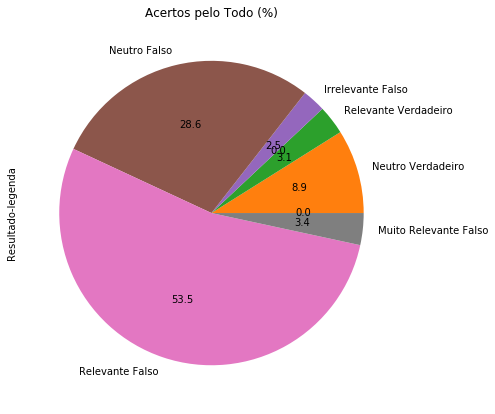

Taxa de Acerto: 12.000 %


In [39]:
pelotodo = dft['Resultado-legenda'].value_counts()/len(nome_resultado)
tododado = pelotodo.reindex(['Irrelevante Verdadeiro','Neutro Verdadeiro','Relevante Verdadeiro','Muito Relevante Verdadeiro','Irrelevante Falso','Neutro Falso','Relevante Falso','Muito Relevante Falso'])
plot = tododado.plot(kind='pie',title='Acertos pelo Todo (%)',autopct='%.1f',figsize=(7, 7))
ver=verifica(xx,cat)
plt.show()
print("Taxa de Acerto: {:.3f} %".format(acerto*100))

___
### Verificando a performance

Agora você deve testar o seu classificador com a base de Testes.

___
### Concluindo

## Aperfeiçoamento:

Os trabalhos vão evoluir em conceito dependendo da quantidade de itens avançados:

* Limpar: \n, :, ", ', (, ), etc SEM remover emojis
* Corrigir separação de espaços entre palavras e emojis ou emojis e emojis
* Propor outras limpezas e transformações que não afetem a qualidade da informação ou classificação
* Criar categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante (3 categorias: C, mais categorias conta para B)
* Explicar por que não posso usar o próprio classificador para gerar mais amostras de treinamento
* Propor diferentes cenários para Naïve Bayes fora do contexto do projeto
* Sugerir e explicar melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* Montar um dashboard que periodicamente realiza análise de sentimento e visualiza estes dados

# Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**